# RL homework 2
**Due date: 26nd March 2021, 4:00pm **

Name: Daniel May

Student number: 18144954

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<student_id>_ucldm_rl2.ipynb`** before the deadline above.

## Context

In this assignment, we will take a first look at learning algorithms for sequential decision problems.

## Background reading

* Sutton and Barto (2018), Chapters 3 - 6

# The Assignment

### Objectives

You will use Python to implement several reinforcement learning algorithms.

You will then run these algorithms on a few problems, to understand their properties.

# Setup

### Import Useful Libraries

In [1]:
import matplotlib.collections as mcoll
import matplotlib.path as mpa
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

### Set options

In [2]:
np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-colorblind')

### Some grid worlds

In [3]:
W = -100  # wall
G = 100  # goal

GRID_LAYOUT = np.array([
  [W, W, W, W, W, W, W, W, W, W, W, W],
  [W, W, 0, W, W, W, W, W, W, 0, W, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, G, 0, W],
  [W, 0, 0, 0, W, W, W, W, 0, 0, 0, W],
  [W, 0, 0, 0, W, W, W, W, 0, 0, 0, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, W],
  [W, W, 0, 0, 0, 0, 0, 0, 0, 0, W, W],
  [W, W, W, W, W, W, W, W, W, W, W, W]
])

class Grid(object):

  def __init__(self, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = GRID_LAYOUT
    self._start_state = (2, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy

  @property
  def number_of_states(self):
      return self._number_of_states

  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x

  def obs_to_state(self, obs):
    x = obs % self._layout.shape[1]
    y = obs // self._layout.shape[1]
    s = np.copy(grid._layout)
    s[y, x] = 4
    return s

  def step(self, action):
    y, x = self._state
    
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    reward = self._layout[new_y, new_x]
    if self._layout[new_y, new_x] == W:  # wall
      discount = 0.9
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = -1.
      discount = 0.9
    else:  # a goal
      discount = 0.
      new_state = self._start_state

    if self._noisy:
      width = self._layout.shape[1]
      reward += 10*np.random.normal(0, width - new_x + new_y)

    self._state = new_state
    return reward, discount, self.get_obs()

  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout != W, interpolation="nearest", cmap='pink')
    plt.gca().grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(2, 2, r"$\mathbf{S}$", ha='center', va='center')
    plt.text(9, 2, r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)


In [4]:
SMALL_GRID_LAYOUT = np.array([
  [W, W, W, W, W],
  [W, W, 3, W, W],
  [W, W, 0, W, W],
  [W, 1, 0, W, W],
  [W, W, 0, W, W],
  [W, W, 0, 4, W],
  [W, W, W, W, W]
])


def plot_small_grid(version=1):
  plt.imshow(SMALL_GRID_LAYOUT < -1, interpolation='nearest', cmap='pink_r',
             vmin=-0.2, vmax=1.2)
  if version == 1:
    plt.text(2, 1, '$+3$', ha='center', va='center', fontsize=12)
    plt.text(1, 3, '$+1$', ha='center', va='center', fontsize=12)
    plt.text(3, 5, '$+4$', ha='center', va='center', fontsize=12)
  else:
    plt.text(2, 1, '$+2$', ha='center', va='center', fontsize=12)
    plt.text(1, 3, '$+1$', ha='center', va='center', fontsize=12)
    plt.text(3, 5, '$+5$', ha='center', va='center', fontsize=12)
  plt.text(2, 3, '$S$', ha='center', va='center', fontsize=12)
  h, w = SMALL_GRID_LAYOUT.shape
  for r in np.arange(0.5, h):
    plt.plot([-0.5, w - 0.5], [r, r], '-k', lw=3, alpha=0.4)
  for c in np.arange(0.5, w):
    plt.plot([c, c], [-0.5, h - 0.5], '-k', lw=3, alpha=0.4)
  plt.xticks([]); plt.yticks([]);

### Helper functions
(You should not have to change, or even look at, these.  Do run the cell to make sure the functions are loaded though.)

In [5]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = grid.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += reward
    return mean_reward/float(number_of_steps)

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(grid, values, colormap='pink', vmin=0, vmax=10):
  plt.imshow(values - 1000*(grid<0), interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_action_values(grid, action_values, vmin=-5, vmax=5):
  q = action_values
  fig = plt.figure(figsize=(10, 10))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  for a in [0, 1, 2, 3]:
    plt.subplot(4, 3, map_from_action_to_subplot(a))
    plot_values(grid, q[..., a], vmin=vmin, vmax=vmax)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(4, 3, 5)
  v = np.max(q, axis=-1)
  plot_values(grid, v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")
  
  # Plot arrows:
  plt.subplot(4, 3, 11)
  plot_values(grid, grid==0, vmax=1)
  for row in range(len(grid)):
    for col in range(len(grid[0])):
      if grid[row][col] == 0:
        argmax_a = np.argmax(q[row, col])
        if argmax_a == 0:
          x = col
          y = row + 0.5
          dx = 0
          dy = -0.8
        if argmax_a == 1:
          x = col - 0.5
          y = row
          dx = 0.8
          dy = 0
        if argmax_a == 2:
          x = col
          y = row - 0.5
          dx = 0
          dy = 0.8
        if argmax_a == 3:
          x = col + 0.5
          y = row
          dx = -0.8
          dy = 0
        plt.arrow(x, y, dx, dy, width=0.02, head_width=0.4, head_length=0.4, length_includes_head=True, fc='k', ec='k')

def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])


def colorline(x, y, z):
    """
    Based on:
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """
    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=plt.get_cmap('copper_r'),
                              norm=plt.Normalize(0.0, 1.0), linewidth=3)

    ax = plt.gca()
    ax.add_collection(lc)
    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments


def plotting_helper_function(_x, _y, title=None, ylabel=None):
  z = np.linspace(0, 0.9, len(_x))**0.7
  colorline(_x, _y, z)
  plt.plot(0, 0, '*', color='#000000', ms=20, alpha=0.7, label='$w^*$')
  plt.plot(1, 1, '.', color='#ee0000', alpha=0.7, ms=20, label='$w_0$')
  min_y, max_y = np.min(_y), np.max(_y)
  min_x, max_x = np.min(_x), np.max(_x)
  min_y, max_y = np.min([0, min_y]), np.max([0, max_y])
  min_x, max_x = np.min([0, min_x]), np.max([0, max_x])
  range_y = max_y - min_y
  range_x = max_x - min_x
  max_range = np.max([range_y, range_x])
  plt.arrow(_x[-3], _y[-3], _x[-1] - _x[-3], _y[-1] - _y[-3], color='k',
            head_width=0.04*max_range, head_length=0.04*max_range,
            head_starts_at_zero=False)
  plt.ylim(min_y - 0.2*range_y, max_y + 0.2*range_y)
  plt.xlim(min_x - 0.2*range_x, max_x + 0.2*range_x)
  ax = plt.gca()
  ax.ticklabel_format(style='plain', useMathText=True)
  plt.legend(loc=2)
  plt.xticks(rotation=12, fontsize=10)
  plt.yticks(rotation=12, fontsize=10)
  plt.locator_params(nbins=3)
  if title is not None:
    plt.title(title, fontsize=20)
  if ylabel is not None:
    plt.ylabel(ylabel, fontsize=20)
  

# Section 1: Tabular RL _(60 pts in total for the whole section)_

In this section, observations will be states in the environment, so the agent state, environment state, and observation will all be the same, and we will use the word `state` interchangably with `observation`.  You will implement agents, which should be in pure Python - so you cannot use JAX/TensorFlow/PyTorch to compute gradients. Using `numpy` is fine.

## Q1: A small grid world _(10 pts in total)_

Consider the grid MDP below:

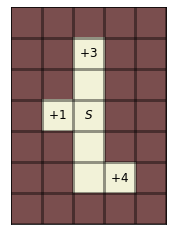

In [6]:
plot_small_grid()

The agent starts at the state marked $S$, and  can move up, left, right, or down.  Whenever it enters a cell with a positive number, the agent receives that reward and the episode terminates.
### Q1.1 [**3 pts**]
Use the code below to plot the value of the optimal policy from the starting state, $v_*(S)$, as a function of the discount factor $\gamma$.

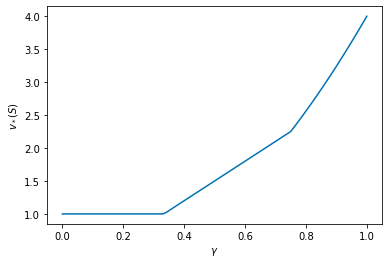

In [7]:
def v(discount):
  return max(discount * 3, 1, discount**2 * 4)

# Don't change this function
def plot_v():
  discounts = np.arange(0, 1.001, 0.01)
  plt.plot(discounts, [v(g) for g in discounts])
  plt.xlabel('$\gamma$')
  plt.ylabel('$v_*(S)$')

plot_v()

### Q1.2 [**2 pts**]

Specify the optimal policy, as a function of $\gamma$.

### Answer

The optimal policy is given by:

$ \pi_* = 
\begin{cases}
    \text{Go to +1},& \text{if } 1 = max(3 \gamma, 1, 4 \gamma^2) \\
    \text{Go to +3},& \text{if } 3 \gamma = max(3 \gamma, 1, 4 \gamma^2) \\
    \text{Go to +4},& \text{if } 4 \gamma^2 = max(3 \gamma, 1, 4 \gamma^2)
\end{cases}
$

### Q1.3 [**2 pts**]
Consider the variation of this problem shown in the next plot.

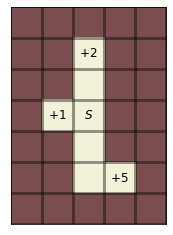

In [8]:
plot_small_grid(version=2)

Suppose a behavioural scientist was doing an experiment where they gave rewards to an animal.  Suppose the setting was as depicted above, where the rewards for instance correspond to food or some other kind of treat (e.g., 5 food pellets at the location marked $+5$). It turns out that, after repeatedly exploring the grid, the animal seems to prefer going up to the reward of $+2$.

Prove that in the MDP depicted above no scalar discount $\gamma \in [0, 1]$ exists for which the optimal policy is to go to $+2$.

### Answer

The optimal policy would be to go to $+2$ if its discounted reward was greater than or equal to that of going to each of $+1$ or $+5$. Mathematically, this gives us two inequalities, which we can get in terms of $\gamma$:

Firstly:

\begin{equation*}
2 \gamma \geq 1 \implies \gamma \geq \dfrac{1}{2}
\end{equation*}

Secondly:
\begin{equation*}
2 \gamma \geq 5 \gamma^2 \implies \dfrac{2}{5} \geq \gamma
\end{equation*}

These inequalities for $\gamma$ contradict each other, and show it would never be optimal to go to $+2$ in this case.

### Q1.4 [**3 pts**]
In the same setting as the previous question, now consider the following generalised definition of a Monte Carlo return
\begin{align*}
G_t
& = R_{t+1} + f(R_{t+1} + f(R_{t+2} + f(\ldots))) \\
& = R_{t+1} + f(G_{t+1}) \,,
\end{align*}
In this formulation, we get standard discounting when we define $f(x) = \gamma x$. Consider the following alternative where instead of multiplying with a factor $\gamma$, we raise the value to the power: $f(x) = x^\gamma$.  Does this mathematical model better explain the observed behaviour, in the sense that a $\gamma$ exists for which the optimal policy goes to $+2$?  If so, give such a value for $\gamma$, and prove that the policy of going to $+2$ is optimal with that choice.  If not, prove that no such $\gamma$ exists.


### Answer

The policy of going to $+2$ is optimal if the reward is greater than or equal to the reward for the policies of going to each of $+1$ and $+5$.

The value of going to $+1$ is: $G_t = 1$

The value of going to $+2$ is: $G_t = 0 + f(G_{t+1}) = 2^{\gamma}$

The value of going to $+5$ is: $0 + f(R_{t+1} + f(R_{t+2})) = f(f(R_{t+2})) = (5^\gamma)^\gamma = 5^{\gamma^2}$.

Going to $+2$ is better than $+1$ if:

\begin{equation*}
2^\gamma > 1 \implies \gamma \log 2 \geq 0 \implies \gamma \geq 0
\end{equation*}

Going to $+2$ is better than $+5$ if:
\begin{equation*}
2^\gamma \geq 5^{\gamma^2} \implies \gamma \log 2 \geq \gamma^2 \log 5 \implies \dfrac{\log 2}{\log 5} \geq \gamma
\end{equation*}

Therefore, going to $+2$ is the best policy if $0 \leq \gamma \leq \dfrac{\log 2}{\log 5}$. For example, $\gamma = 0.40$ would make going to $+2$ optimal.

# Implementing algorithms

**Minimal agent interface**:

Each agent should implement the following methods:

### `__init__(self, number_of_actions, number_of_states, initial_observation, ...)`:
The constructor will provide the agent the number of actions, number of states, and the initial state. You can get the initial state by first instatiating an environment, using `grid = Grid()`, and then calling `grid.get_obs()`. The constructor may accept additional arguments (denoted here by the ellipsis `...`) depending on the specific algorithm implemented by the agent.

### `step(self, reward, discount, next_state)`:

The step method of an agent should update its internals, in whatever way is appropriate for its learning algorithm, and return a new action to be executed in the environment.

When the discount is zero ($\text{discount} = \gamma = 0$), then the `next_state` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_state})$" in the update, because $\gamma = 0$ (for whatever definition of $v$ is appropriate---for instance, $v(s)$ could be defined in terms of action values estimates that we are learning, for instance by $v(s) = \max_a q(s, a)$).  Therefore, the end of an episode can be seamlessly handled with the same step function.

**Note on the initial action**:

Some algorithms (Q-learning, Sarsa) need to remember the last action in order to update its value when they see the next state and reward.  In the constructor (`__init__`), make sure you set the initial action to zero, e.g.,
```
def __init__(...):
  (...)
  self._last_action = 0
  (...)
```
In our experiments the helper functions above will execute the action `0` (which corresponds to `up` in the grid world) as the initial action to begin the run loop of the experiment.  This initial action is only executed once, and the beginning of the very first episode---not at the beginning of each episode.

### A random agent

Below we show a reference implementation of a simple random agent, implemented according to the interface above.

In [9]:
class Random(object):

  def __init__(self, number_of_actions, number_of_states, initial_state):
    self._number_of_actions = number_of_actions

  def step(self, reward, discount, next_state):
    next_action = np.random.randint(self._number_of_actions)
    return next_action

### The grid

The cell below shows the `Grid` environment that we will use in this section. Here `S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-100` for bumping into a wall, `+100` for reaching the goal, and `-1` otherwise.  The episode ends when the agent reaches the goal, and otherwise continues.  The discount, on continuing steps, is $\gamma = 0.9$.  Feel free to reference the implemetation of the `Grid` above, under the header "a grid world".

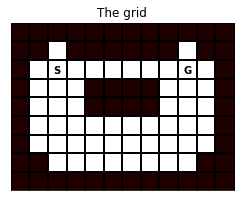

In [10]:
grid = Grid()
grid.plot_grid()


## Q2: Implement TD learning **[5 pts]**
Implement an agent that acts randomly, and _on-policy_ estimates state values $v(s)$, using one-step TD learning with step size $\alpha=0.1$.

In addition to the base interface, also implement a property `state_values(self)` returning the vector of all state values (one value per state).

You should be able to use the `__init__` as provided below, so you just have to implement the `step` function.  We store the initial state in the constructor because you need its value on the first `step` in order to compute the TD error when the first transition has occurred.  

**Hint**: in the `step` you similarly will want to store the previous state to be able to compute the next TD error on the next step.


In [11]:
class RandomTD(object):

  def __init__(self, number_of_states, number_of_actions, initial_state, step_size=0.1):
    self._values = np.zeros(number_of_states)
    self._state = initial_state
    self._number_of_actions = number_of_actions
    self._step_size = step_size

  @property
  def state_values(self):
    return self._values

  def step(self, reward, discount, next_state):
    # Perform one-step TD update
    td_target = reward + discount * self._values[next_state]
    td_error = td_target - self._values[self._state]
    self._values[self._state] += self._step_size * td_error
    self._state = next_state

    # Choose the next action randomly
    next_action = np.random.randint(self._number_of_actions)
    return next_action

### Run the next cell to run the `RandomTD` agent on a grid world.

If everything worked as expected, the plot below will show the estimates state values under the random policy. This includes values for unreachable states --- on the walls and on the goal (we never actually reach the goal --- rather, the episode terminates on the transition to the goal.  The values on the walls and goal are, and will always remain, zero (shown in orange below).

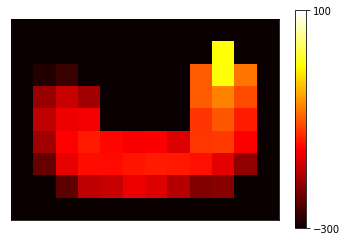

In [12]:
# Do not modify this cell.
agent = RandomTD(grid._layout.size, 4, grid.get_obs())
run_experiment(grid, agent, int(1e5))
v = agent.state_values
plot_values(GRID_LAYOUT, v.reshape(grid._layout.shape), colormap="hot", vmin=-300, vmax=100)

## Q3: Policy iteration **[5 pts]**
We used TD to do policy evaluation for the random policy on this problem.  Consider doing policy improvement, by taking the greedy policy with respect to a one-step look-ahead.  For this, you may assume we have a true model, so for each state and for each action we can look at the value of the resulting state, and would then pick the action with the highest reward plus subsequent state value. In other words, you can assume we can use $q(s, a) = \mathbb{E}[ R_{t+1} + \gamma v(S_{t+1}) \mid S_t = s, A_t = a]$, where $v$ is the value function learned by TD as implemented. Then we consider the policy that picks the action with the highest action value $q(s, a)$. You do **not** have to implement this, just answer the following question.

The above amounts to performing an iteration of policy evaluation and policy improvement.  If we repeat this process over and over again, and repeatedly evaluate the greedy policy and then perform an improvement step by picking the greedy policy, would the policy eventually become optimal?  Explain why or why not in at most three sentences.

> The policy would not become optimal, as the starting value estimates found by policy evaluation with TD for the random policy estimated very negative rewards along the short, optimal route along the top due to bumping into the wall, compared to following the safer, lower route. Performing policy iteration where the policy evaluation is with respect to the greedy policy would leave negative estimates along the top path, as it would not investigate that route, and improvement with the greedy policy would continue to recommend the lower, safer route, and therefore not explore the top path. Appropriate value estimates will therefore not diffuse across the top path, so the policy will not become optimal.


## Q4: Implement a general Q-learning agent **[15 pts]**
Implement a  **general Q-learning** agent that learns action values from experience.   The agent must act according to an $\epsilon$-greedy policy over its action values.  It must be configurable so as to implement any of **Sarsa**, **Expected Sarsa**, **Q-learning**,  and **double Q-learning**.

The `__init__` must accept two functions `target_policy` and `behaviour_policy` as arguments.   The function `behaviour_policy(action_values)` should map `action_values` to a single action. 

For instance, the random policy can be implemented as:
```
def behaviour_policy(action_values):
  return np.random.randint(len(action_values))
```

The target policy is defined by a function `target_policy(action_values, action)`, which returns **a vector** with one probability per action.  The `action` argument is used for instance by Sarsa (where the target policy is a greedy distribution with its peak on the selected action).

For instance, the random target policy is:
```
def target_policy(action_values, unused_action):
  number_of_actions = len(action_values)
  return np.ones((number_of_actions,))/number_of_actions
```

The `__init__` must also accept  a `double` boolean flag. Note that this is compatible with any choice of `target_policy` and `behaviour_policy`. For instance, if the `target_policy` is the policy described above for Sarsa and `double=True`, the algorithm should implement **double Sarsa**. Note that we then need two action-value functions.

You should be able to use the `__init__` as provided below, so you just have to implement the `step` function.  We store the initial state in the constructor because you need its value on the first `step` in order to compute the update on the first transition in the agent's lifetime.  


In [13]:
class GeneralQ(object):

  def __init__(self, number_of_states, number_of_actions, initial_state,
               target_policy, behaviour_policy, double, step_size=0.1):
    # Settings.
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._target_policy = target_policy
    self._double = double
    # Initial state.
    self._s = initial_state
    # Tabular q-estimates.
    self._q = np.zeros((number_of_states, number_of_actions))
    if double:
      self._q2 = np.zeros((number_of_states, number_of_actions))
    # The first action in an agent's lifetime is always 0(=up) in our setup.
    self._last_action = 0

  @property
  def q_values(self):
    return (self._q + self._q2)/2 if self._double else self._q

  def step(self, reward, discount, next_state):
    action = self._behaviour_policy(self.q_values[next_state])

    if self._double:
      # Choose q or q2 to update at random
      if np.random.random() > 0.5:
        # Update q
        target = reward + discount * np.dot(self._q2[next_state], self._target_policy(self._q[next_state], action))
        self._q[self._s][self._last_action] += self._step_size * (target - self._q[self._s][self._last_action])
      else:
        # Update q2
        target = reward + discount * np.dot(self._q[next_state], self._target_policy(self._q2[next_state], action))
        self._q2[self._s][self._last_action] += self._step_size * (target - self._q2[self._s][self._last_action])
    else:
      # Update q
      target = reward + discount * np.dot(self._q[next_state], self._target_policy(self._q[next_state], action))
      self._q[self._s][self._last_action] += self._step_size * (target - self._q[self._s][self._last_action])
    
    self._s = next_state
    self._last_action = action

    return action

## Experiment 1: Run the cells below

This will train Q-learning, Sarsa, Expected Sarsa, and double Q-learning agents on the deterministic version of the Grid problem.

The agents will be trained  with a step size $\alpha=\frac{1}{10}$ and $\epsilon$-greedy behaviour, with $\epsilon=\frac{1}{4}$.

The plots will show action values for each of the actions, as well as a state value defined by $v(s) = \max_a q(s, a)$.

In [14]:
# Agent settings.
# Do not modify this cell.
epsilon = 0.25
step_size = 0.1

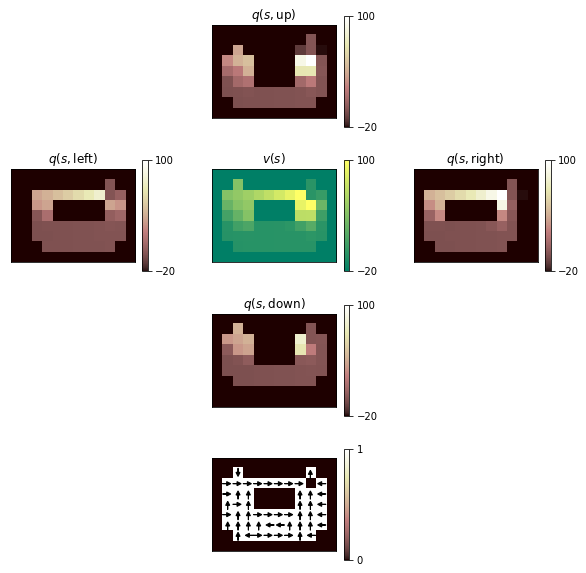

In [15]:
# Q-learning
# Do not modify this cell.
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)
def target_policy(q, a):
  return np.eye(len(q))[np.argmax(q)]

learned_qs = []
for _ in range(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=False, step_size=step_size)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-20, vmax=100)

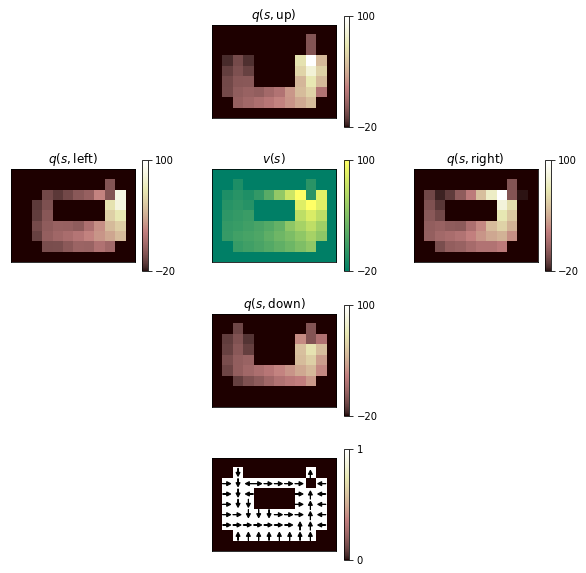

In [16]:
# Sarsa
# Do not modify this cell.
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)
def target_policy(q, a):
  return np.eye(len(q))[a]

learned_qs = []
for _ in range(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=False, step_size=step_size)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-20, vmax=100)

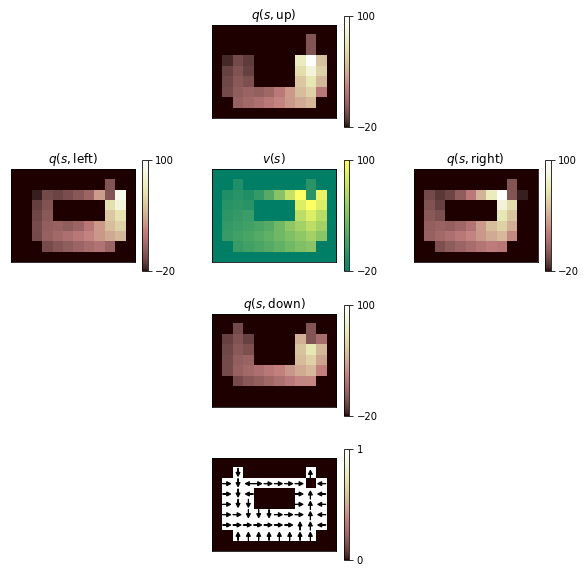

In [17]:
# Expected Sarsa
# Do not modify this cell.
grid = Grid()
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)
def target_policy(q, a):
  greedy = np.eye(len(q))[np.argmax(q)]
  return greedy - greedy*epsilon + epsilon/4 

learned_qs = []
for _ in range(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=False, step_size=step_size)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-20, vmax=100)

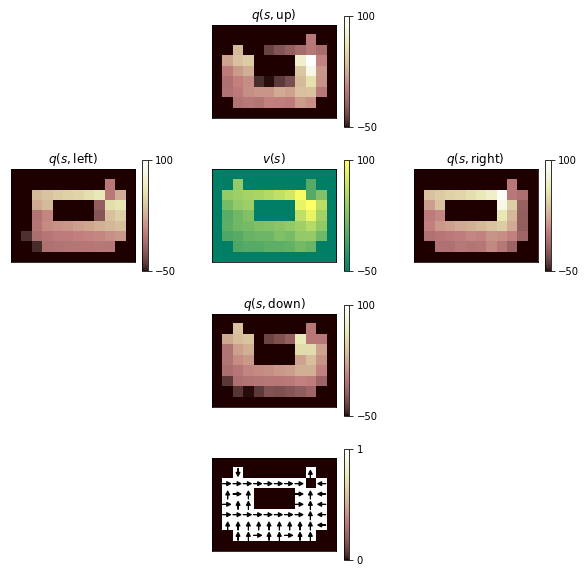

In [20]:
# Double Q-learning
# Do not modify this cell.
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)
def target_policy(q, a):
  # Place equal probability on all actions that achieve the `max` value.
  # This is equivalent to `return np.eye(len(q))[np.argmax(q)]` for Q-learning
  # But results in slightly lower variance updates for double Q.
  max_q = np.max(q)
  pi = np.array([1. if qi == max_q else 0. for qi in q])
  return pi / sum(pi)

learned_qs = []
for _ in range(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=True, step_size=step_size)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-50, vmax=100)

## Q5: Analyse results _(10 pts in total)_

Consider the greedy policy with respect to the estimated values learned by each of the four agents.

**[5 pts]** How and why do the policies found by Q-learning, Sarsa, Expected Sarsa, and double Q-learning differ? Explain notable qualitative differences in at most four sentences.

> Q-learning accurately learns the shortest route from the start to the goal, so its greedy policy would be the optimal one, though it underestimates the values when taking the lower route.
>
> The greedy policy with respect to Double Q-learning also suggests the short, optimal route along the top, but unlike Q-learning, it decouples action selection and evaluation, and learns reliable estimates along the lower route, and has reasonable value estimates for every state and action.
>
> As Sarsa is an on-policy algorithm following $\epsilon$-greedy actions, its greedy policy suggests following the safer, but longer, lower route along the middle path, so that it has a lesser probability of bumping into a wall.
>
> As the step-size is relatively small at $0.1$ and the number of steps in the experiment is sufficiently large, Expected Sarsa and Sarsa find extremely similar, if not identical solutions, both suggesting following the safer, longer, lower route - if the step-size were larger or number of steps smaller, we may have expected Expected Sarsa to find a better solution than Sarsa.

**[5 pts]** Which of the algorithms, out of Q-learning, Sarsa, Expected Sarsa, and double Q-learning with the learning parameters (exploration, step size) as discussed above, will *in general* yield higher returns on average during learning?  You are allowed to specify a partial (rather than a full) ordering over the algorithms, but try to be as specfic as you can. Explain your answer in at most four sentences.

> As the step-size is relatively small at $0.1$ and the number of steps in the experiments is relatively large, we might expect Sarsa to yield average returns that are almost as high, if not as high, as Expected Sarsa.
> As Q-learning is an off-policy algorithm and will tend to follow the shorter, top path, we would expect its return to be lower than Sarsa and Expected Sarsa on average, since with $\epsilon = 0.25$ it will bump into the wall and receive a negative reward quite often.
> The double Q-learning algorithm explores more than Q-learning, particularly in safer, wider regions such as the lower route, so we might expect its average reward to be higher than Q-learning, as it may bump into the wall less often. However, while following the routes that its policy suggests, it may still bump into the wall more often than the on-policy Sarsa and Expected Sarsa algorithms, so have a lower average return than these.

## Experiment 2: Run the cells below

This will train Q-learning and double Q-learning agents on the stochastic version of the Grid problem.

In the noisy version, a zero-mean Gaussian is added to all rewards.  

The variance of this noise is higher the further to the left you go, and the further down.

The agents will be trained  with a step size $\alpha=\frac{1}{10}$ and $\epsilon$-greedy behaviour, with $\epsilon=\frac{1}{4}$.

The plots will show action values for each of the actions, as well as a state value defined by $v(s) = \max_a q(s, a)$.

In [ ]:
# Agent settings.
# Do not modify this cell.
epsilon = 0.25
step_size = 0.1

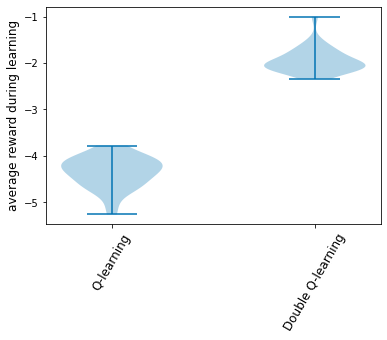

In [ ]:
# Q-learning and double Q-learning.
# Do not modify this cell.

def target_policy(q, a):
  max_q = np.max(q)
  pi = np.array([1. if qi == max_q else 0. for qi in q])
  return pi / sum(pi)

def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)

mean_reward_q_learning = []
mean_reward_double_q_learning = []
for _ in range(30):
  grid = Grid(noisy=True)
  q_agent = GeneralQ(
      grid._layout.size, 4, grid.get_obs(),
      target_policy, behaviour_policy, double=False, step_size=step_size)
  dq_agent = GeneralQ(
      grid._layout.size, 4, grid.get_obs(),
      target_policy, behaviour_policy, double=True, step_size=step_size)
  mean_reward_q_learning.append(run_experiment(grid, q_agent, int(2e5)))
  mean_reward_double_q_learning.append(run_experiment(grid, dq_agent, int(2e5)))

plt.violinplot([mean_reward_q_learning, mean_reward_double_q_learning])
plt.xticks([1, 2], ["Q-learning", "Double Q-learning"], rotation=60, size=12)
plt.ylabel("average reward during learning", size=12)
ax = plt.gca()
ax.grid(0)

## Q6: Analyse results **[8 pts]**

Which among Q-learning and Double Q-learning has a higher average reward? Explain why, discussing at least a) the dynamics of the algorithm, b) how this affects behaviour, and c) why the behaviour yields higher rewards for one algorithm rather than the other. Be concise.

> The average reward is higher for Double Q-learning. As there is a zero-mean Gaussian added to each reward with greater variance the further left and down you go, Q-learning suffers from maximization bias and overestimates the value of going left and down, since it takes a maximum of the estimates it receives, so some are likely to be positive. Q-learning may therefore spend more time than it should around the left and bottom areas, incurring $-1$ rewards on average for each unnecessary step that it was not aiming for the goal. 
> Double Q-learning keeps two independent estimates, randomly using one to determine the maximizing action and the other to estimate its value, so it can accurately estimate the true value of the left and bottom states, avoiding the bias.

## Q7: Target Q-learning **[7 pts]**

Consider a new algorithm which we will refer to as **target Q-learning**. The target Q-learning algorithm applies Q-learning updates in the form 
$\ \ q(S_t, A_t) \leftarrow R_{t+1} + \gamma \max_a q'(S_{t+1}, a) \ \ $  
where the values $q'$ have been pre-trained by running $\epsilon$-greedy Expected Sarsa, and are then held fixed throughout training.

We can now imagine now to train both Q-learning and target Q-learning on the deterministic Grid problem.  In both Q-learning and target Q-learning the behaviour policy will select actions based on the same $\epsilon$-greedy policy that was used to pre-train the $q'$ values, but using the current action-value estimates (not the fixed target values $q'$).

Explain concisely which of the two algorithms will perform better and why. (If you're tempted to answer 'it depends', be sure to be clear what you think it depends on, and why. Don't be vague: point could be subtracted for including irrelevant or false statements, even if the correct answer is also given.)

> Target Q-learning will have a greater average reward during learning, as Q-learning will try to follow the shorter, more dangerous route along the top, where its $\epsilon$-greedy behaviour makes it likely to bump into the wall and receive large negative rewards. Target Q-learning will choose the maximizing actions according to the pre-trained values from Expected Sarsa, so it will follow the longer, middle path through the lower route, where it is less likely to bump into the wall, so its reward during training will be larger.
>
> However, Q-learning would perform better after training if you were to execute the greedy policies according to the algorithms, as it would follow the shortest path safely along the top, whereas Target Q-learning would take the longer, safer path to the goal.

# Section 2: Off-policy Bellman operators with function approximation
# _(40 pts total for the whole section)_

## Q8: Bellman operator for prediction **[10 pts]**

We are going to implement a Bellman operator for a simple MDP. You should:


1. Write a value function `v(w, x)` that outputs a linear value estimate when we have weights `w` (a numpy vector) and feature vector `x` (a numpy vector of the same size).
2. Write an operator function `T(w, pi, mu, l, g)` that takes weights `w`, a target policy `pi`, a behaviour policy `mu`, a trace parameter `l`, and a discount `g`, and outputs an off-policy-corrected lambda-return.  For this question, implement the standard importance-weighted per-decision lambda-return. There will only be two actions, with the same policy in each state, so we can define `pi` to be a number which is the target probability of selecting action `a` in any state (s.t. `1 - pi` is the probability of selecting `b`), and similarly for the behaviour `mu`.
3. Write an expected weight update, that uses the above two functions to compute the **expected** weight update.  The expectation should take into account the probabilities of actions in the future, as well as the steady-state (=long-term) probability of being in a state.  The step size of the update should be $\alpha=0.1$.

There are two states, $s_1$ and $s_2$.  All rewards are zero, and therefore can be ignored.  The state features $x_1 = x(s_1)$ and $x_2 = x(s_2)$ for the two states are $x_1 = [1, 1]^{\top}$ and $x_2 = [2, 1]^{\top}$.  In each state, there are two actions, $a$ and $b$.  Action $a$ always transitions to state $s_1$, action $b$ always transitions to state $s_2$.

![MDP](https://hadovanhasselt.files.wordpress.com/2020/02/mdp.png)


In [ ]:
# state features (do not change)
x1 = np.array([1., 1.])
x2 = np.array([2., 1.])

def v(w, x):
  return w.dot(x)

def T(w, pi, mu, l, g):
  return g*(1-l)*(pi*v(w, x1) + (1 - pi)*v(w, x2)) / (1 - g*l)

def expected_update(w, pi, mu, l, g, lr):
  T_val = T(w, pi, mu, l, g)
  return lr*(mu*(T_val - v(w, x1))*x1 + (1-mu)*(T_val - v(w, x2))*x2)

##Experiment 3: run the cell below
The cell below runs an experiment, across different target policies and trace parameters $\lambda$.

The plots below the cell will show how the weights move within the 2-dimensional weight space, starting from $w_0 = [1, 1]^{\top}$ (shown as red dot).  The optimal solution $w_* = [0, 0]^{\top}$ is also shown (as black star).

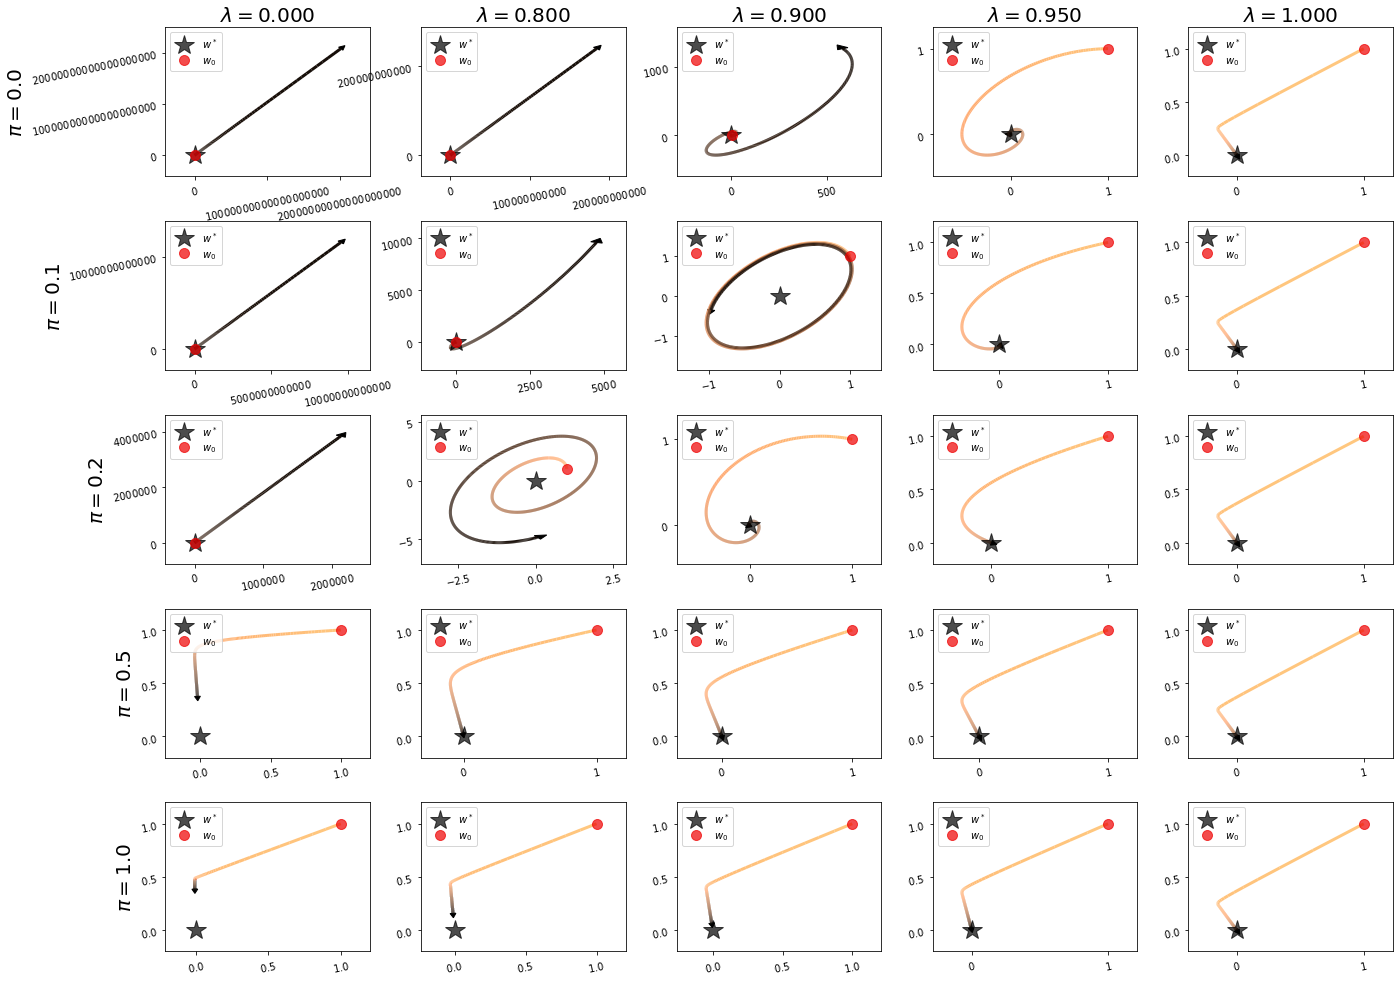

In [ ]:
def generate_ws(w, pi, mu, l, g):
  """Apply the expected update 1000 times"""
  ws = [w]
  for _ in range(1000):
    w = w + expected_update(w, pi, mu, l, g, lr=0.1)
    ws.append(w)
  return np.array(ws)

mu = 0.5  # behaviour
g = 0.99  # discount

lambdas = np.array([0, 0.8, 0.9, 0.95, 1.])
pis = np.array([0., 0.1, 0.2, 0.5, 1.])

fig = plt.figure(figsize=(22, 17))
fig.subplots_adjust(wspace=0.25, hspace=0.3)

for r, pi in enumerate(pis):
  for c, l in enumerate(lambdas):
    plt.subplot(len(pis), len(lambdas), r*len(lambdas) + c + 1)
    w = np.ones_like(x1)
    ws = generate_ws(w, pi, mu, l, g)
    title = '$\\lambda={:1.3f}$'.format(l) if r == 0 else None
    ylabel = '$\\pi={:1.1f}$'.format(pi) if c == 0 else None
    plotting_helper_function(ws[:, 0], ws[:, 1], title, ylabel)

## Q9: Analyse results (30 pts total)
1. **[2 pts]** How many of the above 25 experiments diverge?
1. **[4 pts]** Why are the results asymmetric across different $\pi$?  In particular, explain why the results look different when comparing $\pi = \pi(a | \cdot) = 0$ to $\pi(a | \cdot) = 1$.
1. **[4 pts]** For which policies $\pi$, is the true value function $v_{\pi}$ representable in the above feature space (spanned by $x_1, x_2$).
1. **[4 pts]** For which combination of $\pi(a)$ and $\lambda$ does the expected update (with uniform random behaviour) converge? (Do not limit the answer to the subset of values in the plots above, but to all choices of $\lambda$ and $\pi$, but do restrict yourself to state-less policies, as above, for which the action probabilities are equal in the two states.)
1. **[4 pts]** Why do all the plots corresponding to full Monte Carlo look the same?
1. **[4 pts]** Why do the plots corresponding to full Monte Carlo have the shape they do?
1. **[4 pts]** How would the results above change (at high level, not in terms of precise plots) if the behaviour policy $\mu$ would select action $a$ more often (e.g., $\mu = 0.8$)?  How would the results change if the behaviour would select $a$ less often (e.g., $\mu = 0.2$)?
1. **[4 pts]** Consider again the orginal experiment, where data is gathered under uniformly random behaviour policy. What would the updates to the vectors $w$ be under the $L_\infty$ norm? You can either run the experiment or give the closed-form update in an equation.


## Put answers to Q9 in this cell:
1. 7 of the 25 experiments diverge.
2. When $\pi(a | \cdot) = 0$, bootstrapping occurs on feature $x_2$ only, which has a larger value than $x_1$ for the starting weights, so the expected update is positive for most values of $\lambda$. This process is reinforcing, and the weights become ever larger, diverging unless the amount of bootstrapping is greatly reduced so $\lambda$ is close to $1$.
When $\pi(a | \cdot) = 1$, bootstrapping occurs on feature $x_1$ only, which has a smaller value than $x_2$ for the starting weights, so the expected update can be negative, and the weights can converge to the optimal solution of $w_* = [0, 0]^{\top}$.

3. The true value function is representable for all $\pi$, with $w=[0, 0]^{\top}$ as the two feature vectors are linearly independent.
4. Using the expected update, we have the formula for updates given by:
\begin{equation*}
w_{t+1} = w_{t} + \alpha [ \mu (T(w_{t}, \pi, \mu, \lambda, \gamma) - w_{t} \cdot x_{1}) x_1 + (1-\mu)(T(w_{t}, \pi, \mu, \lambda, \gamma) - w_{t} \cdot x_2) x_2 ]
\end{equation*}
where
\begin{equation*}
T(w_{t}, \pi, \mu, \lambda, \gamma) = \dfrac{\gamma (1 - \lambda) [\pi w_{t} \cdot x_{1} + (1-\pi) w_{t} \cdot x_{2}]}{1 - \gamma \lambda}
\end{equation*}
Factorising out $w_{t}$ and using that there is uniform random behavior so $\mu = \frac{1}{2}$, we have
\begin{align*}
w_{t+1} &= w_{t} + w_{t} \dfrac{\alpha}{2} [ ( \dfrac{\gamma(1-\lambda)(\pi x_{1} + (1-\pi) x_{2})}{1 - \gamma \lambda} - x_{1}) \cdot x_{1} + ( \dfrac{\gamma(1-\lambda)(\pi x_{1} + (1-\pi) x_{2})}{1 - \gamma \lambda} - x_{2}) \cdot x_{2}] \\
&= w_{t} (1 + \dfrac{\alpha}{2} [ ( \dfrac{\gamma(1-\lambda)(\pi x_{1} + (1-\pi) x_{2})}{1 - \gamma \lambda} - x_{1}) \cdot x_{1} + ( \dfrac{\gamma(1-\lambda)(\pi x_{1} + (1-\pi) x_{2})}{1 - \gamma \lambda} - x_{2}) \cdot x_{2}])
\end{align*}
Therefore, the combinations of $\pi(a)$ and $\lambda$ for which the expected update converges satisfy:
\begin{equation*}
1 + \dfrac{\alpha}{2} [ ( \dfrac{\gamma(1-\lambda)(\pi x_{1} + (1-\pi) x_{2})}{1 - \gamma \lambda} - x_{1}) \cdot x_{1} + ( \dfrac{\gamma(1-\lambda)(\pi x_{1} + (1-\pi) x_{2})}{1 - \gamma \lambda} - x_{2}) \cdot x_{2}] < 1
\end{equation*}
Or equivalently:
\begin{equation*}
( \dfrac{\gamma(1-\lambda)(\pi x_{1} + (1-\pi) x_{2})}{1 - \gamma \lambda} - x_{1}) \cdot x_{1} + ( \dfrac{\gamma(1-\lambda)(\pi x_{1} + (1-\pi) x_{2})}{1 - \gamma \lambda} - x_{2}) \cdot x_{2} < 0
\end{equation*}
We can write a method which carries this out:

```python
def does_converge(lr, g, l, pi):
  return 1 + lr/2*((g*(1-l)*(pi*x1+(1-pi)*x2)/(1-g*l)-x1).dot(x1)+
                   (g*(1-l)*(pi*x1+(1-pi)*x2)/(1-g*l)-x2).dot(x2)) < 1
```

5. In the full Monte Carlo case, where $\lambda = 1.0$, the operator is always $0$, so $\pi$ has no effect on the expected weight updates, which are therefore the same for all values of $\pi$.
6. The full Monte Carlo case is guaranteed to converge. The expected weight update for this case has the form:
\begin{equation*}
w_{t+1} = w_{t} - \dfrac{1}{20}[(w_{t} \cdot x_{1}) x_{1} + (w_{t} \cdot x_{2}) x_{2}]
\end{equation*}
Due to the dot products with the state features and the weight vector, the weight vector coordinates interact in the update formula.
The first coordinate of the weight vector reduces more quickly than the second, as the state features for $x_2$ are greater in the first coordinate. However, the first coordinate overshoots 0 at first rather than staying there. Once it has done this, the update for the first weight coordinate can be positive and the second negative, so that their interaction cancels out, and the weight can converge to $w_* = [0, 0]^{\top}$.
7. With $\mu=0.8$, more of the experiments would diverge, as more weight would be given to the expected update term for feature $x_1$, which will make the expected update even more positive for most values of $\lambda$, and more reinforcing to divergence. With $\mu=0.2$, more of the experiments would converge to the optimal $w_* = [0, 0]^{\top}$, as more weight will be given to the expected update term for feature $x_2$.
8. Choosing to run the experiment, the updates for the weight vector under the $L_\infty$ norm would be given by the following code. The outputted graphs are also shown in the cell below.

```python
def weight_update(w, pi, mu, l, g, lr):
  eq = T(w, pi, mu, l, g) - np.array([v(w, x1), v(w, x2)])

  if abs(eq[0]) == max(abs(eq)):
    return lr * np.sign(eq[0]) * x1
  else:
    return lr * np.sign(eq[1]) * x2
```

Plots of the experiment carried out in 9.8. using the $L_\infty$ norm.

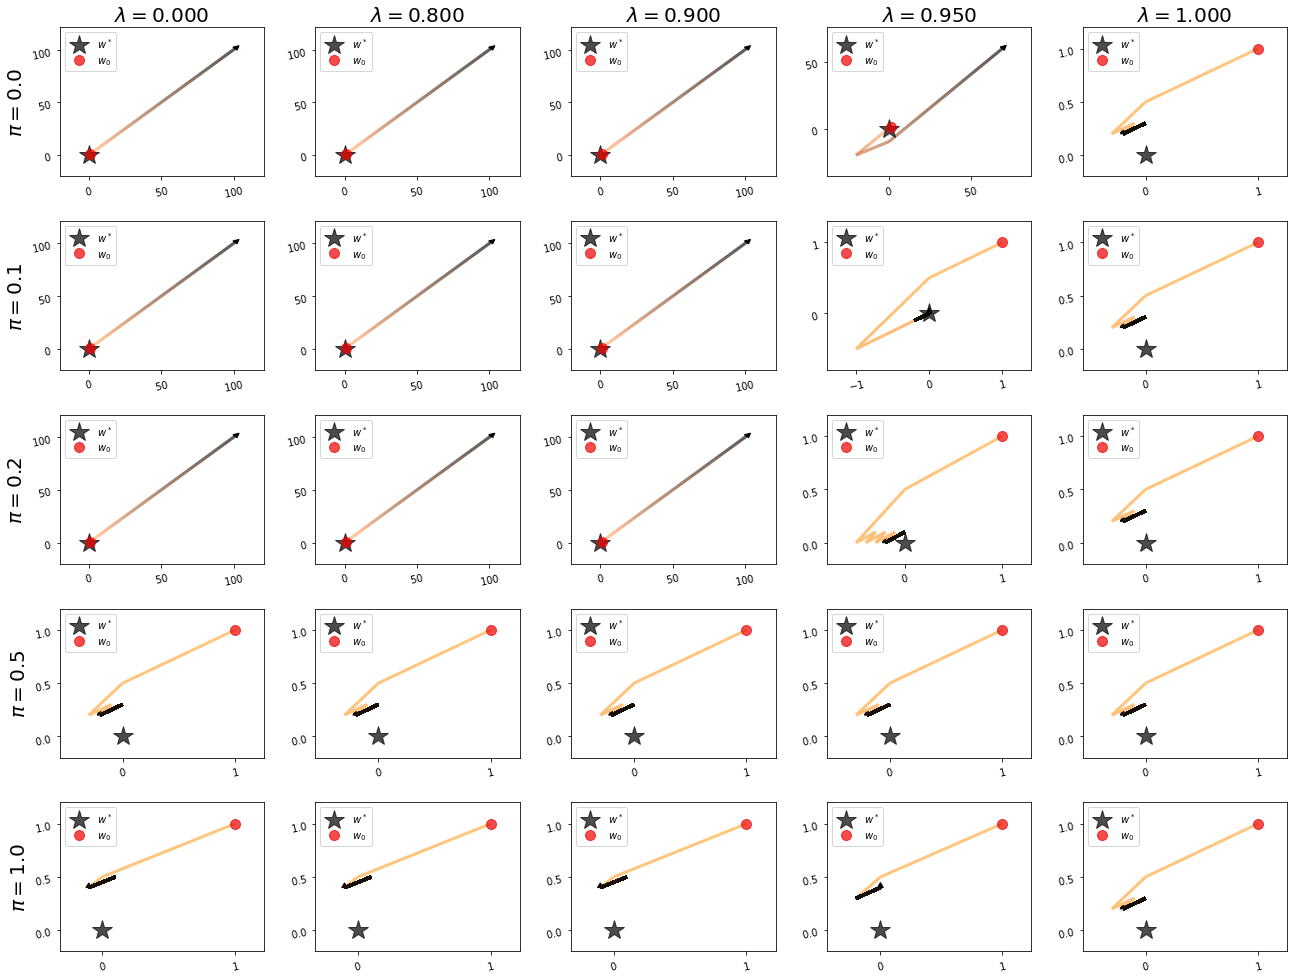